# Adaptive Systeme - Hausaufgabe 2
Henry Fock

## Aufbau und Formeln für ein neuronales Netz
Ein neuronales Netz ist aus mehreren Komponenten aufgebaut:
- Vollvernetzte (lineare) Schicht. Dies entspricht dem Matrix - Vektorprodukt von Gewichtematrix und Eingabevektor. Die Zeilen der Gewichtematrix entsprechen den Gewichten der Eingangsneuronen (Spaltenvektor): $$f(x) = W^Tx$$
- (Nicht lineare) Aktivierungs-/ Transferfunktion. Hier wird die Fermi-/ Sigmoidfunktion verwendet: $$\sigma(x) = \frac{1}{1 + \exp(-x)}$$
- Fehlerfunktion. Hier wird zum einen die Categorical Cross Entropy und der Mean Squered Error verwendet. Dabei ist $x$ das Ergebnis des Netzes und $y$ der Zielwert. $x$ und $y$ sind jeweils Spaltenvektoren.
\begin{align*}
\text{MSE}(x,y) &= \frac{1}{|x|}\sum_{i=0}^{|x|} \left(x_i - y_i \right)^2 \\
\text{CCE}(x,y) &= -\sum_{i=0}^{|x|} y_i \cdot \log(x_i)
\end{align*}

Ein Forward-pass, bis zum Fehler $E$ über eine Schicht entspricht:
$$E\left(\sigma\left(f\left(x\right)\right)\right)$$
Über zwei Schichten:
$$E\left(\sigma_2\left(f_2\left(\sigma_1\left(f_1\left(x\right)\right)\right)\right)\right)$$

### Formeln für Backpropegation
Außerdem werden die partiellen Ableitungen für das Gradientenabstiegsverfahren der einzelnen Funktionen benötigt. Die lineare Schicht benötigt eine mit Bezug auf die Gewichte, um diese zu ändern und eine mit Bezug auf den Eingang, um den Gradienten in die darüberliegenden Schichten weiterzuleiten.
Die Gradienten lassen sich über die Kettenregel berechnen:

\begin{align*}
\frac{\partial E}{\partial w_{ij}^2} &= \frac{\partial f_2}{\partial w_{ij}^2} \cdot \frac{\partial \sigma_2}{\partial f_2} \cdot \frac{\partial E}{\partial \sigma_2}  \\
\delta_2 &= \frac{\partial \sigma_2}{\partial f_2} \cdot \frac{\partial E}{\partial \sigma_2} \\
\frac{\partial E}{\partial w_{ij}^1} &= \frac{\partial f_1}{\partial w_{ij}^1}\cdot \frac{\partial \sigma_1}{\partial f_1} \cdot \frac{\partial f_2}{\partial \sigma_1} \cdot \delta_2 
\end{align*}

Die Formeln für die Gradienten sind:
\begin{align*}
\frac{\partial f}{\partial w_{ij}} &= x_i \\
\frac{\partial f_2}{\partial \sigma_1} &= W \\
\frac{\partial \sigma}{\partial f} &= \sigma(f)\cdot (1 - \sigma(f)) \\
\frac{\partial \text{MSE}}{\partial \sigma_i} &= \frac{1}{|\sigma|}\cdot 2(\sigma_i - y_i) \\
\frac{\partial \text{CCE}}{\partial \sigma_i} &= -\frac{y}{\sigma_i}
\end{align*}


## Implementierung: Definieren von abstrakten Oberklassen für Schichten Fehler und Modelle

In [1]:
from typing import *
from abc import ABC, abstractmethod
import numpy as np


class Layer(ABC):
    @abstractmethod
    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def train(self, lr: float = 0.01) -> None:
        raise NotImplementedError()


class Loss(ABC):
    @abstractmethod
    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        raise NotImplementedError()

    @abstractmethod
    def backwards(self) -> np.ndarray:
        raise NotImplementedError()

class Metric(ABC):
    @abstractmethod
    def metric(self, x: np.ndarray, y: np.ndarray) -> float:
        raise NotImplementedError()


class Model(ABC):
    @abstractmethod
    def predict(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @abstractmethod
    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int = 10,
        lr: float = 0.01,
        batch_size: int = 1,
        loss_threshold: float = 1e-2,
        shuffle: bool = True,
    ) -> None:
        raise NotImplementedError()


## Implementierung: Implementieren der Layer

In [2]:
class Linear(Layer):
    def __init__(self, num_inputs: int, num_outputs: int, weight_init:str = "uniform") -> None:
        assert weight_init in ("uniform", "normal")

        self.num_inputs = num_inputs
        self.num_inputs = num_outputs

        if weight_init == "uniform":
            self.weights = np.random.rand(num_inputs + 1, num_outputs)
        if weight_init == "normal":
            self.weights = np.random.randn(num_inputs + 1, num_outputs)
        
        # self.weights *= np.sqrt(1.0 / num_inputs)

        self.weight_gradients: np.ndarray = None

        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None

    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        x_bias = np.vstack([np.ones((1, 1)), x])
        out = np.dot(self.weights.T, x_bias)
        if train:
            self.train_input = x_bias
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        self.weight_gradients = np.dot(prev_grads, self.train_input.T).T
        return np.dot(self.weights[1:], prev_grads)

    def train(self, lr: float = 0.01) -> None:
        self.weights -= lr * self.weight_gradients
        self.weight_gradients = None
        self.train_input = None
        self.train_output = None


class Sigmoid(Layer):
    def __init__(self) -> None:
        self.train_input: np.ndarray = None
        self.train_output: np.ndarray = None

    def forward(self, x: np.ndarray, train: bool = False) -> np.ndarray:
        out = 1 / (1 + np.exp(-x))
        if train:
            self.train_input = x
            self.train_output = out
        return out

    def backwards(self, prev_grads: np.ndarray) -> np.ndarray:
        grads = self.train_output * (1 - self.train_output)
        return prev_grads * grads

    def train(self, *_) -> None:
        self.train_input = None
        self.train_output = None

## Implementierung: Implementieren der Fehlerfunktionen

In [3]:
class MeanSquereError(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return np.mean(np.power(x - y, 2))

    def backwards(self) -> np.ndarray:
        out = 2/self.train_y.size*(self.train_x - self.train_y)
        return out

class CategoricalCrossEntropy(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return -np.sum(y * np.log(x))

    def backwards(self) -> np.ndarray:
        out = -(self.train_y / self.train_x)
        return out


class BinaryCrossEntropy(Loss):
    def __init__(self) -> None:
        self.train_x: np.ndarray = 0
        self.train_y: np.ndarray = 0

    def loss(self, x: np.ndarray, y: np.ndarray, train: bool = False) -> float:
        if train:
            self.train_x = x
            self.train_y = y
        return (1/y.size) * np.sum(-(y * np.log(x) + (1-y) * np.log(1-x)))

    def backwards(self) -> np.ndarray:
        out = (1/self.train_y.size) * ((self.train_x - self.train_y) / ((1 - self.train_x) * self.train_x))
        return out



## Implementierung: Metriken

In [4]:
class Accuracy(Metric):
	def metric(self, x: np.ndarray, y: np.ndarray) -> float:
		x = x.astype("uint8")
		y = y.astype("uint8")
		return np.mean(x == y)

## Implementierung: Trainingsroutine im MultilayerPerceptron

### Helferklasse fürs Datenhandling

In [5]:
class Dataset:
    @classmethod
    def shuffle(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
        sampling = np.random.permutation(x.shape[0])
        return x[sampling], y[sampling]

In [25]:
class MultiLayerPerceptron:
    def __init__(self, layers: List[Layer], loss: Loss) -> None:
        self.layers = layers
        self.loss_function = loss

    def predict(self, x: np.ndarray) -> np.ndarray:
        results = np.array([self._forward(sample, train=False) for sample in x])
        return results

    def _forward(self, x: np.ndarray, train: bool) -> np.ndarray:
        intermed_result: np.ndarray = x
        for layer in self.layers:
            intermed_result = layer.forward(intermed_result, train=train)
        return intermed_result

    def _backpropegate(self) -> None:
        gradient = self.loss_function.backwards()
        for layer in self.layers[::-1]:
            gradient = layer.backwards(gradient)

    def _update_weights(self, lr: float = 0.01) -> None:
        for layer in self.layers[::-1]:
            layer.train(lr)

    def train(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int = 10,
        lr: float = 0.01,
        min_delta: float = 1e-5,
        patience: int = 0,
        loss_threshold:float = 1e-2,
        shuffle: bool = True
    ) -> tuple[int, str]:
        epoch: int = 1
        last_loss = 1e5
        patience_counter = 0
        while epoch <= epochs:
            xs, ys = x, y
            if shuffle:
                xs, ys = Dataset.shuffle(x, y)
            for sample_x, sample_y in zip(xs, ys):
                result = self._forward(sample_x, train=True)
                self.loss_function.loss(result, sample_y, train=True)

                self._backpropegate()
                self._update_weights(lr)


            intermed_preds = self.predict(x)
            intermed_loss = self.loss_function.loss(intermed_preds, y)

            if loss_threshold > intermed_loss:
                return (epoch, "Fehlergrenze")

            if min_delta > 0:
                loss_delta = abs(last_loss - intermed_loss)
                last_loss = intermed_loss
                patience_counter += 1

                if loss_delta < min_delta:  
                    if patience_counter > patience:
                        return (epoch, "Konvergenz")
                else:
                    patience_counter = 0

            epoch += 1

        return (epoch - 1, "Abbruch")

## Erstellen von Helferklassen zur Datenrepräsentation
Zuordnung der Segmente mit ihren Indizes:

<img src="Images/d8.png" alt="drawing" width="200"/>

In [7]:
import matplotlib.pyplot as plt


class SevenSegment:
	def __init__(self, encoding: np.ndarray) -> None:
		assert encoding.size == 7
		self.encoding = encoding

	def display(self) -> None:
		img = self.getImage()
		plt.imshow(img)
		plt.show()

	def getImage(self) -> np.ndarray:
		segments = self.getEncoding()
		assert segments.size == 7

		image = np.zeros((5, 3), dtype=np.uint8)
		segment_to_image = {
			0: {"x":[0, 0, 0], "y":[0, 1, 2]},
			1: {"x":[0, 1, 2], "y":[0, 0, 0]},
			2: {"x":[0, 1, 2], "y":[2, 2, 2]},
			3: {"x":[2, 2, 2], "y":[0, 1, 2]},
			4: {"x":[2, 3, 4], "y":[0, 0, 0]},
			5: {"x":[2, 3, 4], "y":[2, 2, 2]},
			6: {"x":[4, 4, 4], "y":[0, 1, 2]},
		}

		for i, segment in enumerate(segments):
			if segment == 1:
				s2i = segment_to_image[i]
				image[s2i["x"], s2i["y"]] = 1

		return image

	def getEncoding(self) -> np.ndarray:
		return self.encoding


def seven_segment_factory_method(char: str) -> SevenSegment:
	assert char in ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "b", "C", "d", "E", "F")
	if char == "0":
		return SevenSegment(np.array([1, 1, 1, 0, 1, 1, 1]))
	if char == "1":
		return SevenSegment(np.array([0, 1, 0, 0, 1, 0, 0]))
	if char == "2":
		return SevenSegment(np.array([1, 0, 1, 1, 1, 0, 1]))
	if char == "3":
		return SevenSegment(np.array([1, 0, 1, 1, 0, 1, 1]))
	if char == "4":
		return SevenSegment(np.array([0, 1, 1, 1, 0, 1, 0]))
	if char == "5":
		return SevenSegment(np.array([1, 1, 0, 1, 0, 1, 1]))
	if char == "6":
		return SevenSegment(np.array([0, 1, 0, 1, 1, 1, 1]))
	if char == "7":
		return SevenSegment(np.array([1, 0, 1, 0, 0, 1, 0]))
	if char == "8":
		return SevenSegment(np.array([1, 1, 1, 1, 1, 1, 1]))
	if char == "9":
		return SevenSegment(np.array([1, 1, 1, 1, 0, 1, 0]))
	if char == "A":
		return SevenSegment(np.array([1, 1, 1, 1, 1, 1, 0]))
	if char == "b":
		return SevenSegment(np.array([0, 1, 0, 1, 1, 1, 1]))
	if char == "C":
		return SevenSegment(np.array([1, 1, 0, 0, 1, 0, 1]))
	if char == "d":
		return SevenSegment(np.array([0, 0, 1, 1, 1, 1, 1]))
	if char == "E":
		return SevenSegment(np.array([1, 1, 0, 1, 1, 0, 1]))
	if char == "F":
		return SevenSegment(np.array([1, 1, 0, 1, 1, 0, 0]))


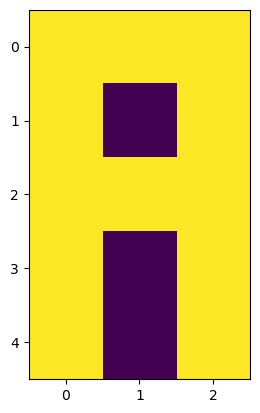

In [8]:
seven_segment_factory_method("A").display()

# Aufgabe 1
Untersuchen Sie wie die Lernf¨ahigkeit und -geschwindigkeit des Netz von

- der Anzahl der zu erlernenden Muster d.h. 0 – 9 oder 0 – 15...
- der Anzahl der Eingabeneuronen, also entweder 4 oder 10/16...
- der Anzahl der verborgenen Neuronen Schichten...
- der Anzahl der Neuronen in der jeweiligen Schicht...

...abhängt

## Erzeugen des Trainingsdatensatzes
Für das Training werden zum einen One-Hot-Encodings für Dezimal- und Hexadezimalwerte, und zum anderen Binärdarstellungen für die Dezimalwerte als Input verwendet.
Die Ausgabe ist jeweils die 7-Segment Schaltung für den jeweiligen Wert.

In [9]:
chars9 = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
chars16 = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "b", "C", "d", "E", "F"]
seven_segments9 = [seven_segment_factory_method(x) for x in chars9]
seven_segments16 = [seven_segment_factory_method(x) for x in chars16]
x9 = np.expand_dims(np.identity(len(chars9)), -1)
x16 = np.expand_dims(np.identity(len(chars16)), -1)
xb = np.expand_dims(((np.array([0,1,2,3,4,5,6,7,8,9]).reshape(-1,1) & (1 << np.arange(4))) > 0).astype("uint8"), -1)
y9 = np.expand_dims(np.array([x.getEncoding() for x in seven_segments9]), -1)
y16 = np.expand_dims(np.array([x.getEncoding() for x in seven_segments16]), -1)
yb = y9


## Erzeugen des Netzwerkes und anstoßen des Trainings
Es werden verschiedene Netzwerkarchitekturen getestet:

- Keine versteckte Ebene:	(n $\rightarrow$ 7)
- Eine versteckte Ebene: 	(n $\rightarrow$ n $\rightarrow$ 7)
- Eine versteckte Ebene: 	(n $\rightarrow$ 7 $\rightarrow$ 7)
- Eine versteckte Ebene: 	(n $\rightarrow$ 5 $\rightarrow$ 7)
- Zwei versteckte Ebenen: 	(n $\rightarrow$ n $\rightarrow$ n $\rightarrow$ 7)
- Zwei versteckte Ebenen: 	(n $\rightarrow$ 7 $\rightarrow$ 7 $\rightarrow$ 7)
- Zwei versteckte Ebenen: 	(n $\rightarrow$ 5 $\rightarrow$ 5 $\rightarrow$ 7)
- Drei versteckte Ebenen: 	(n $\rightarrow$ n $\rightarrow$ n $\rightarrow$ n $\rightarrow$ 7)
- Drei versteckte Ebenen: 	(n $\rightarrow$ 7 $\rightarrow$ 7 $\rightarrow$ 7 $\rightarrow$ 7)
- Drei versteckte Ebenen: 	(n $\rightarrow$ 5 $\rightarrow$ 5 $\rightarrow$ 5 $\rightarrow$ 7)

Es wird für maximal 2000 Epochen trainiert. Es wurde ein verfrühtes Stoppen eingeführt, wenn sich der Fehler über einen Zeitraum von 5 Epochen nicht um mindestens 0,00001 verbessert hat. Dann wird eine Konvergenz angenommen.

Die Lernrate ist auf 0,5 festgesetzt.

Es wird Stochastic Gradient Descent (SGD) zum Training verwendet, also eine Batchgröße von 1. 

Als Fehlerfunktion wird der MSE verwendet. 

Als Klassifizierungsmetrik wird Accuracy verwendet. Dabei wird die Korrektheit eines Segment als TP angesehen, nicht die komplette Schaltung. Zum Vergleich wird die Ausgabe des Netzes auf 0 oder 1 gerundet.

In [26]:
import os

def plot_predictions(encodings:np.ndarray, image_file_name:str = None) -> None:
	_, axs = plt.subplots(4,4)
	axs = axs.flatten()
	for i, encoding in enumerate(encodings):
		img = SevenSegment(encoding).getImage()
		axs[i].imshow(img)
	if image_file_name is not None:
		plt.savefig(image_file_name)
	else:
		plt.show()


def test_networks(x:np.ndarray, y:np.ndarray, loss: Loss, image_file_path:str = "", plot_output:bool = True) -> None:
	np.random.seed(0)

	networks: dict[list[Layer]] = {
		"0 hidden": [Linear(x.shape[1], 7), Sigmoid()],
		f"1 hidden mit {x.shape[1]} Neuronen": [Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], 7), Sigmoid()],
		"1 hidden mit 7 Neuronen": [Linear(x.shape[1], 7), Sigmoid(), Linear(7, 7), Sigmoid()],
		"1 hidden mit 5 Neuronen": [Linear(x.shape[1], 5), Sigmoid(), Linear(5, 7), Sigmoid()],
		f"2 hidden mit {x.shape[1]}-{x.shape[1]} Neuronen": [Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], 7), Sigmoid()],
		"2 hidden mit 7-7 Neuronen": [Linear(x.shape[1], 7), Sigmoid(), Linear(7, 7), Sigmoid(), Linear(7, 7), Sigmoid()],
		"2 hidden mit 5-5 Neuronen": [Linear(x.shape[1], 5), Sigmoid(), Linear(5, 5), Sigmoid(), Linear(5, 7), Sigmoid()],
		f"3 hidden mit {x.shape[1]}-{x.shape[1]}-{x.shape[1]} Neuronen": [Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], x.shape[1]), Sigmoid(), Linear(x.shape[1], 7), Sigmoid()],
		"3 hidden mit 7-7-7 Neuronen": [Linear(x.shape[1], 7), Sigmoid(), Linear(7, 7), Sigmoid(), Linear(7, 7), Sigmoid(), Linear(7, 7), Sigmoid()],
		"3 hidden mit 5-5-5 Neuronen": [Linear(x.shape[1], 5), Sigmoid(), Linear(5, 5), Sigmoid(), Linear(5, 5), Sigmoid(), Linear(5, 7), Sigmoid()],
	}
	
	stats:dict = dict()
	for description, network in networks.items():
		mlp = MultiLayerPerceptron(network, loss)
		epoch, criteria = mlp.train(x, y, epochs=2000, lr=0.5, min_delta=1e-5, patience=5, loss_threshold=0)
		pred = mlp.predict(x)
		if plot_output:
			encodings = np.squeeze(np.round(pred, 0))
			plot_predictions(encodings, os.path.join(image_file_path, description + ".jpg"))

		metric = Accuracy()
		loss_value = loss.loss(pred, y)
		acc = metric.metric(np.round(pred,0), y)
		stats["Konfiguration"] = stats.get("Konfiguration", []) + [description]
		stats["Trainingsdauer"] = stats.get("Trainingsdauer", []) + [epoch]
		stats["Terminierungsgrund"] = stats.get("Terminierungsgrund", []) + [criteria]
		stats["Fehler"] = stats.get("Fehler", []) + [loss_value]
		stats["Genauigkeit"] = stats.get("Genauigkeit", []) + [acc]

	return stats

In [16]:
import pandas as pd

In [29]:
stats = test_networks(x9, y9, MeanSquereError(), "Images/Outputs/out9/", plot_output=False)
pd.DataFrame(stats)

,Konfiguration,Trainingsdauer,Terminierungsgrund,Fehler,Genauigkeit
0,0 hidden,694,Konvergenz,0.005920,1.000000
1,1 hidden mit 10 Neuronen,760,Konvergenz,0.004446,1.000000
2,1 hidden mit 7 Neuronen,827,Konvergenz,0.004890,1.000000
3,1 hidden mit 5 Neuronen,1058,Konvergenz,0.006484,1.000000
4,2 hidden mit 10-10 Neuronen,1910,Konvergenz,0.005076,1.000000
5,2 hidden mit 7-7 Neuronen,2000,Abbruch,0.009050,1.000000
6,2 hidden mit 5-5 Neuronen,2000,Abbruch,0.022271,0.985714
7,3 hidden mit 10-10-10 Neuronen,2000,Abbruch,0.213017,0.671429
8,3 hidden mit 7-7-7 Neuronen,897,Konvergenz,0.212872,0.671429
9,3 hidden mit 5-5-5 Neuronen,406,Konvergenz,0.212859,0.671429


In [30]:
stats = test_networks(x16, y16, MeanSquereError(), "Images/Outputs/out16/", plot_output=False)
pd.DataFrame(stats)

,Konfiguration,Trainingsdauer,Terminierungsgrund,Fehler,Genauigkeit
0,0 hidden,696,Konvergenz,0.005925,1.000000
1,1 hidden mit 16 Neuronen,646,Konvergenz,0.003173,1.000000
2,1 hidden mit 7 Neuronen,760,Konvergenz,0.004252,1.000000
3,1 hidden mit 5 Neuronen,1061,Konvergenz,0.006491,1.000000
4,2 hidden mit 16-16 Neuronen,7,Konvergenz,0.321285,0.678571
5,2 hidden mit 7-7 Neuronen,1498,Konvergenz,0.049492,0.955357
6,2 hidden mit 5-5 Neuronen,1719,Konvergenz,0.041447,0.964286
7,3 hidden mit 16-16-16 Neuronen,7,Konvergenz,0.321134,0.678571
8,3 hidden mit 7-7-7 Neuronen,932,Konvergenz,0.214285,0.678571
9,3 hidden mit 5-5-5 Neuronen,394,Konvergenz,0.214292,0.678571


In [31]:
stats = test_networks(xb, yb, MeanSquereError(), "Images/Outputs/outb/", plot_output=False)
pd.DataFrame(stats)

,Konfiguration,Trainingsdauer,Terminierungsgrund,Fehler,Genauigkeit
0,0 hidden,954,Konvergenz,0.093637,0.900000
1,1 hidden mit 4 Neuronen,1959,Konvergenz,0.030939,0.971429
2,1 hidden mit 7 Neuronen,1951,Konvergenz,0.008243,1.000000
3,1 hidden mit 5 Neuronen,1831,Konvergenz,0.024061,0.985714
4,2 hidden mit 4-4 Neuronen,166,Konvergenz,0.212210,0.671429
5,2 hidden mit 7-7 Neuronen,2000,Abbruch,0.012101,1.000000
6,2 hidden mit 5-5 Neuronen,147,Konvergenz,0.212630,0.671429
7,3 hidden mit 4-4-4 Neuronen,40,Konvergenz,0.212906,0.671429
8,3 hidden mit 7-7-7 Neuronen,987,Konvergenz,0.212758,0.685714
9,3 hidden mit 5-5-5 Neuronen,266,Konvergenz,0.212906,0.671429


## Interpretation

**One-Hot-Encodings** haben eine 1:1 Relation mit der Schaltung einer 7-Segmentanzeige, da jede Eingabe direkt auf ihre Ausgabe gemappt werden kann. Zur Erkennung wird hier also keine versteckte Schicht benötigt und kann mit einer linearen Schicht realisiert werden. Dabei macht es keinen Unterschied, ob die Eingabe aus 9 oder 16 oder $n$ Eingaben besteht. Auch die Geschwindigkeit bis zur Konvergenz unterscheidiet sich nicht signifikant, da nur für einen Schicht die Gradienten berechnet werden müssen und diese direkt vom Input abhängen. Daher ist die Anzahl benötigter Epochen, bis zur Konvergenz, konstant gegen die Eingabegröße.
Gemessen an der Anzahl benötigter Parameter kann eine Eine lineare Schicht als optimal angenommen werden.
Ein Bottleneck von 5 Neuronen in der versteckten Schicht führt auch noch zu 100% Genauigkeit, benötigt aber fast doppelt so lange zum konvergieren wie die linearen Netzwerke.
2 versteckte Schichten konnten bei $n=9$ noch trainiert werden, 3 führen zu einer komplexeren Fehlertopographie, weshalb sich das Netzwerk schnell in lokalen Minima festfährt und konvergiert, ohne die optimale Lösung zu finden. 

**Binär-Kodierungen** haben keine 1:1 Relation mit der Segmentschaltung, da für die Segmente "entweder - oder" entschiedungen getroffen werden müssen. Daher ist ein Netzwerk mit 0 versteckten Schichten nicht in der Lage eine optimale Lösung zu finden. Die beste Konfiguration, gemessen an der Anzahl Parameter, ist eine versteckte Schicht mit 7 Neuronen.
Auch hier zeigt sich, dass bei 3 versteckte Schichten, sich das Netzwerk in lokalen Minima verfährt und konvergiert, ohne ein globales Optimum zu finden. Insgesammt lässt sich vermuten, dass das Netzwerk vorm letzten Schritt eine versteckte Schicht haben muss mit mindestens der selben Neuronenzahl, wie Ausgänge, um die $xor$ Verknüpfungen zu realisieren. Die Begründung ist, dass nur die beiden Netzwerke mit 7 Neuronen in der letzten (versteckten) Schicht in der Lage waren eine Accuracy von 100% zu erreichen.

# Aufgabe 2
Frage: Was eignet sich zur Klassifikation besser, der mittlere quadratische Fehler (MSE) oder die categorival-cross-entropy (CCE)?

Antwort: Die CCE benötigt einen Wahrscheinlichkeitsvektor als Eingabe, um zu funktionieren. 
Der Grund liegt darin, dass $y_i \cdot \log(\hat{y})$ 0 ergibt für alle Ergebnisse, die eine 0 als erwartete Ausgabe haben. 
Wenn $\hat{y}$ ein Wahrscheinlichkeitsvektor ist, hängt $\hat{y}_i$ von den anderen Stellen im Vektor ab. 
Haben die anderen Stellen einen hohen Wert, so muss der Wert von $\hat{y}_i$ zwangsläufig klein sein und führt somit zu einem hohen Fehler.
Die CCE eignet sich also nur für Probleme, bei denen genau eine Klasse vorhergesagt werden soll.
Das vorliegende Problem ist aber ein Mehrklassenproblem, in dem jedes Ausgabeneuron 0 oder 1 schalten kann, unabhängig von den anderen.
Nutzt man CCE als Fehlerfunktion, so lernt das Netzwerk, dass es alle Gewichte auf 1 setzen muss, da so das Ergebniss immer 1 und der Fehler nahe 0 ist, weil die Stellen, die 0 sein sollten, nicht mit in den Fehler einfließen.

Als Alternative kann die Binary-Cross-Entropy (BCE) verwendet werden:
$$
\frac{1}{|X|}\sum_{x\in X} -(y \cdot \log(x) + (1-y) \cdot \log(1-x))
$$
BCE ist quasi die CCE pro Ausgabe, bestehend aus Wahrscheinlichkeit und Gegenwahrscheinlichkeit.

Als Antwort auf dei Frage lässt sich somit per Ausschluss sagen, dass MSE besser geeignet ist für dieses Problem, als CCE, da die Vorraussetzung für CCE nicht gegeben ist!